# Graph-level label only membership inference attack (GLO-MIA).
As described here: https://arxiv.org/pdf/2503.19070. This attack method is suitable for multi-graph datasets, and assumes the strictest black box scenario in which the attacker has no access to model architecture, and queries only return labels insteasd of logits/probabilities.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ogb.graphproppred import PygGraphPropPredDataset

In [3]:
import torch
import numpy as np

from tqdm import tqdm
from multiprocessing import Pool
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from torch_geometric import nn as gnn, transforms as T
from torch_geometric.datasets import TUDataset, PPI
from torch_geometric.loader import DataLoader as GDataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import auc as AUC, roc_curve, roc_auc_score, accuracy_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from ml_util import (
    CustomGATModel, 
    GenericAttackModel, 
    LogitsDefenseModel,
    predict_multi_graph, 
    predict, 
    train_model_multi_graph,
    test_model_multi_graph,
    load_model, get_accuracy, 
    get_auroc_score, 
    train_model
)
from util import onehot_transform, graph_train_test_split, calculate_robustness_scores
from train_models import get_dataset, shadow_target_split, train_gat
from glo_mia import search_scaler

In [4]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
dataset_name = 'PROTEINS'
METRIC = 'robustness'

In [6]:
# Number of times to train a target/shadow model on the same set of data 
NUM_RUNS = 7
NUM_PERTURB = 500

In [7]:
dataset = get_dataset(dataset_name)
num_feat = dataset[0].x.shape[1]
num_categories = dataset[0].y.shape[1]

In [8]:
scores_t_train, scores_t_test = [], [] # Robustness scores of the target train/test data
scores_s_train, scores_s_test = [], [] # Robustness scores of the shadow train/test data
t_models, s_models = [], [] # Lists of target and shadow models

dataset = get_dataset(dataset_name) 
t_dataset_train, t_dataset_test, s_dataset_train, s_dataset_test = shadow_target_split(dataset, target_test_size=0.25, shadow_test_size=0.25)
util_loss_fn = nn.CrossEntropyLoss() 

for i in range(NUM_RUNS):
    print(f'Run #{i+1}')
    # Train target model
#     t_save_path = f'mia-models/t_model_gat_{dataset_name}_{i}.pth'
    t_save_path = None
    t_model, _ = train_gat(dataset_name, 't', t_dataset_train, dataset_test=t_dataset_test, save_path=t_save_path, device=DEVICE, verbose=1)
    # Train shadow model
#     s_save_path = f'mia-models/s_model_gat_{dataset_name}_{i}.pth'
    s_save_path = None
    s_model, _ = train_gat(dataset_name, 's', s_dataset_train, dataset_test=s_dataset_test, save_path=s_save_path, device=DEVICE, verbose=1)
    
    t_model = LogitsDefenseModel(t_model).to(DEVICE)
    s_model = LogitsDefenseModel(s_model).to(DEVICE)
    t_model.eval()
    s_model.eval()
    # Target model performance on train/test data
    _, acc, f1, auc = test_model_multi_graph(t_model, util_loss_fn, t_dataset_train, device=DEVICE)
    print(f'Target model (test): acc: {acc:.4f}, F1: {f1:.4f}, AUROC: {auc:.4f}')
    
    _, acc, f1, auc = test_model_multi_graph(t_model, util_loss_fn, t_dataset_test, device=DEVICE)
    print(f'Target model (test): acc: {acc:.4f}, F1: {f1:.4f}, AUROC: {auc:.4f}')
    
    # Shadow model performance on test data
    _, acc, f1, auc = test_model_multi_graph(s_model, util_loss_fn, s_dataset_train, device=DEVICE)
    print(f'Shadow model (train): acc: {acc:.4f}, F1: {f1:.4f}, AUROC: {auc:.4f}')
    
    _, acc, f1, auc = test_model_multi_graph(s_model, util_loss_fn, s_dataset_test, device=DEVICE)
    print(f'Shadow model (test): acc: {acc:.4f}, F1: {f1:.4f}, AUROC: {auc:.4f}')
    
    # Get robustness scores for shadow model training/test data
#     scalers, thresholds, all_acc, all_auroc, s_scores_train, s_scores_test = search_scaler(s_model, s_dataset_train, s_dataset_test,
#                                                                                            n_perturb_per_graph=1000, scaler_max=5.5, ds=0.3, metric=METRIC)
    scalers = np.arange(0.1, 5., 0.25)
    s_scores_train = np.array([calculate_robustness_scores(s_model, s_dataset_train, n_perturb_per_graph=NUM_PERTURB, scaler=scaler, device=DEVICE, metric=METRIC) for scaler in tqdm(scalers)])
    s_scores_test = np.array([calculate_robustness_scores(s_model, s_dataset_test, n_perturb_per_graph=NUM_PERTURB, scaler=scaler, device=DEVICE, metric=METRIC) for scaler in tqdm(scalers)])
    
    # Get robustness scores for target model training/test data
    t_scores_train = np.array([calculate_robustness_scores(t_model, t_dataset_train, n_perturb_per_graph=NUM_PERTURB, scaler=scaler, device=DEVICE, metric=METRIC) for scaler in tqdm(scalers)])
    t_scores_test = np.array([calculate_robustness_scores(t_model, t_dataset_test, n_perturb_per_graph=NUM_PERTURB, scaler=scaler, device=DEVICE, metric=METRIC) for scaler in tqdm(scalers)])
    
    # Label shadow data as member/non-member to be used as attack model train set
    X = np.concatenate([s_scores_train.T, s_scores_test.T])
    labels = np.array(([1] * len(s_dataset_train)) + ([0] * len(s_dataset_test))).reshape(-1,1)
    y = OneHotEncoder(categories=[[0,1]], sparse_output=False).fit_transform(labels)
    att_dataset = TensorDataset(torch.Tensor(X), torch.Tensor(y))

    # Label target data as member/non-member to be used as attack model test set
    X_test = np.concatenate([t_scores_train.T, t_scores_test.T])
    labels_test = np.array(([1] * len(t_dataset_train)) + ([0] * len(t_dataset_test))).reshape(-1,1)
    y_test = OneHotEncoder(categories=[[0,1]], sparse_output=False).fit_transform(labels_test)
    att_dataset_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    
    # Train attack model
    lr = 0.001
    epochs = 250
    batch_size = 10
    weight_decay = 1e-4

    att_model = GenericAttackModel(num_feat=len(scalers), dropout=0.4).to(DEVICE)
    optimizer = optim.Adam(att_model.parameters(), lr=lr, weight_decay=weight_decay)
    weight = compute_class_weight('balanced', classes=np.unique(y.argmax(axis=1)), y=y.argmax(axis=1))
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))
    train_model(att_model, optimizer, att_dataset, loss_fn, epochs, batch_size, val_dataset=None, device=DEVICE, verbose=1)
    att_model.eval()
    
    # Evaluate attack model on the target and shadow datasets
    att_pred = predict(att_model, att_dataset, device=DEVICE, logits=True, return_type='pt')
    att_pred_test = predict(att_model, att_dataset_test, device=DEVICE, logits=True, return_type='pt')
    
    # Get AUROC on target and shadow datasets
    print(f'Shadow (train) AUROC: {roc_auc_score(y.argmax(axis=1), att_pred[:,1].cpu())}')
    print(f'Target (test) AUROC: {roc_auc_score(y_test.argmax(axis=1), att_pred_test[:,1].cpu())}')
    
    scores_t_train.append(t_scores_train)
    scores_t_test.append(t_scores_test)
    scores_s_train.append(s_scores_train)
    scores_s_test.append(s_scores_test)
    t_models.append(t_model.to('cpu'))
    s_models.append(s_model.to('cpu'))



Run #1


100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


Target model (test): acc: 0.9017, F1: 0.8951, AUROC: 0.9554
Target model (test): acc: 0.6691, F1: 0.5818, AUROC: 0.7169
Shadow model (train): acc: 0.9233, F1: 0.9080, AUROC: 0.9709
Shadow model (test): acc: 0.6929, F1: 0.5743, AUROC: 0.7220


100%|██████████| 250/250 [00:19<00:00, 12.62it/s]


Shadow (train) AUROC: 0.8494176087701267
Target (test) AUROC: 0.5900143194796681
Run #2


100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


Target model (test): acc: 0.8657, F1: 0.8579, AUROC: 0.9432
Target model (test): acc: 0.6331, F1: 0.5565, AUROC: 0.6834
Shadow model (train): acc: 0.9089, F1: 0.8827, AUROC: 0.9748
Shadow model (test): acc: 0.7357, F1: 0.6022, AUROC: 0.7463


100%|██████████| 250/250 [00:20<00:00, 12.43it/s]


Shadow (train) AUROC: 0.8672062350119905
Target (test) AUROC: 0.5676379759501752
Run #3


100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


Target model (test): acc: 0.8921, F1: 0.8849, AUROC: 0.9557
Target model (test): acc: 0.6978, F1: 0.6379, AUROC: 0.7778
Shadow model (train): acc: 0.9353, F1: 0.9194, AUROC: 0.9817
Shadow model (test): acc: 0.7786, F1: 0.6437, AUROC: 0.7730


100%|██████████| 250/250 [00:20<00:00, 12.48it/s]


Shadow (train) AUROC: 0.802500856457691
Target (test) AUROC: 0.6326277107810155
Run #4


100%|██████████| 200/200 [00:59<00:00,  3.36it/s]


Target model (test): acc: 0.9161, F1: 0.9100, AUROC: 0.9702
Target model (test): acc: 0.7050, F1: 0.6306, AUROC: 0.7584
Shadow model (train): acc: 0.7530, F1: 0.7268, AUROC: 0.8448
Shadow model (test): acc: 0.6357, F1: 0.5565, AUROC: 0.6735


100%|██████████| 250/250 [00:20<00:00, 12.48it/s]


Shadow (train) AUROC: 0.8436622130866736
Target (test) AUROC: 0.6107948173835032
Run #5


100%|██████████| 200/200 [00:59<00:00,  3.35it/s]


Target model (test): acc: 0.8801, F1: 0.8756, AUROC: 0.9484
Target model (test): acc: 0.6043, F1: 0.5669, AUROC: 0.6485
Shadow model (train): acc: 0.9233, F1: 0.9036, AUROC: 0.9760
Shadow model (test): acc: 0.7357, F1: 0.6105, AUROC: 0.7342


100%|██████████| 250/250 [00:19<00:00, 12.56it/s]


Shadow (train) AUROC: 0.7935080507022952
Target (test) AUROC: 0.6246226040750134
Run #6


100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


Target model (test): acc: 0.8058, F1: 0.7705, AUROC: 0.8852
Target model (test): acc: 0.6475, F1: 0.5243, AUROC: 0.6888
Shadow model (train): acc: 0.9233, F1: 0.9042, AUROC: 0.9754
Shadow model (test): acc: 0.7143, F1: 0.5833, AUROC: 0.7490


100%|██████████| 250/250 [00:20<00:00, 12.40it/s]


Shadow (train) AUROC: 0.7846094552929086
Target (test) AUROC: 0.6095612718458328
Run #7


100%|██████████| 200/200 [00:59<00:00,  3.36it/s]


Target model (test): acc: 0.9137, F1: 0.9053, AUROC: 0.9637
Target model (test): acc: 0.6547, F1: 0.5294, AUROC: 0.6699
Shadow model (train): acc: 0.9400, F1: 0.9258, AUROC: 0.9842
Shadow model (test): acc: 0.7571, F1: 0.6667, AUROC: 0.7547


100%|██████████| 250/250 [00:20<00:00, 12.40it/s]

Shadow (train) AUROC: 0.7427029804727647
Target (test) AUROC: 0.6705484533236719


In [9]:
# t_dataset_train, t_dataset_test, s_dataset_train, s_dataset_test = shadow_target_split(dataset, target_test_size=0.4, shadow_test_size=0.4)

In [10]:

# Label shadow data as member/non-member to be used as attack model train set
# X = np.concatenate([s_scores_train.T, s_scores_test.T])
s_scores_train = np.stack(scores_s_train).mean(axis=0)
s_scores_test = np.stack(scores_s_test).mean(axis=0)
t_scores_train = np.stack(scores_t_train).mean(axis=0)
t_scores_test = np.stack(scores_t_test).mean(axis=0)
# t_scores_train = scores_t_train[0]
# t_scores_test = scores_t_test[0]

X = np.concatenate([s_scores_train.T, s_scores_test.T])
labels = np.array(([1] * len(s_dataset_train)) + ([0] * len(s_dataset_test))).reshape(-1,1)
y = OneHotEncoder(categories=[[0,1]], sparse_output=False).fit_transform(labels)
att_dataset = TensorDataset(torch.Tensor(X), torch.Tensor(y))

# Label target data as member/non-member to be used as attack model test set
X_test = np.concatenate([t_scores_train.T, t_scores_test.T])
labels_test = np.array(([1] * len(t_dataset_train)) + ([0] * len(t_dataset_test))).reshape(-1,1)
y_test = OneHotEncoder(categories=[[0,1]], sparse_output=False).fit_transform(labels_test)
att_dataset_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

In [11]:
lr = 0.001
epochs = 250
batch_size = 8
weight_decay = 1e-4

att_model = GenericAttackModel(num_feat=len(scalers), dropout=0.4).to(DEVICE)
optimizer = optim.Adam(att_model.parameters(), lr=lr, weight_decay=weight_decay)
weight = compute_class_weight('balanced', classes=np.unique(y.argmax(axis=1)), y=y.argmax(axis=1))

loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))

train_model(att_model, optimizer, att_dataset, loss_fn, epochs, batch_size, 
            val_dataset=att_dataset_test, device=DEVICE, verbose=2)
att_model.eval()

Learning rate: 0.001
No learning rate scheduling!
Training for 250 epochs, with batch size=8
Using device: cuda:0

-----Epoch 1/250-----
Batch 50/70 | loss: 0.6747294999788653 (0.069s) | train acc: 0.6875 | train auc: 0.633947
Batch 70/70 | loss: 0.756763180106803 (0.027s) | train acc: 0.6750 | train auc: 0.609233
Validation: val loss: 0.674 | val acc: 0.520 | val F1: 0.577 | val AUC: 0.703

-----Epoch 2/250-----
Batch 50/70 | loss: 0.666351773764596 (0.068s) | train acc: 0.6375 | train auc: 0.671734
Batch 70/70 | loss: 0.6218116861866461 (0.028s) | train acc: 0.6427 | train auc: 0.683316
Validation: val loss: 0.625 | val acc: 0.664 | val F1: 0.752 | val AUC: 0.710

-----Epoch 3/250-----
Batch 50/70 | loss: 0.6519264663313732 (0.068s) | train acc: 0.6825 | train auc: 0.647855
Batch 70/70 | loss: 0.6523421179763402 (0.027s) | train acc: 0.6715 | train auc: 0.667472
Validation: val loss: 0.623 | val acc: 0.579 | val F1: 0.655 | val AUC: 0.717

-----Epoch 4/250-----
Batch 50/70 | loss: 0.

GenericAttackModel(
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [12]:
# # Create and train target model
# t_model = CustomGATModel(num_feat=num_feat, num_classes=num_categories).to(DEVICE)

# t_save_path = f'mia-models/t_model_gat_{dataset_name}.pth'
# t_model, t_dataset_train, t_dataset_test = load_model(t_model, t_save_path)
# t_model.eval()

In [13]:
# # Create and train shadow model
# s_model = CustomGATModel(num_feat=num_feat, num_classes=num_categories).to(DEVICE)
# s_save_path = f'mia-models/s_model_gat_{dataset_name}.pth'

# s_model, s_dataset_train, s_dataset_test = load_model(s_model, s_save_path)
# s_model.eval()

In [14]:
# logits = predict_multi_graph(s_model, s_dataset_train, device=DEVICE, logits=True, return_type='pt')
# targets = torch.cat([g.y for g in s_dataset_train])
# # get_accuracy(logits, targets)
# get_auroc_score(logits, targets, multiclass=(num_categories>2))

In [15]:
# scalers, thresholds, all_acc, all_auroc, s_scores_train, s_scores_test = search_scaler(s_model, s_dataset_train, s_dataset_test,
#                                                         n_perturb_per_graph=1000, scaler_max=4.1, metric=METRIC)

In [16]:
# t_scores_train = np.array([calculate_robustness_scores(t_model, t_dataset_train, scaler=scaler, device=DEVICE, metric=METRIC) for scaler in tqdm(scalers)])
# t_scores_test = np.array([calculate_robustness_scores(t_model, t_dataset_test, scaler=scaler, device=DEVICE, metric=METRIC) for scaler in tqdm(scalers)])

In [17]:
# X_test = np.concatenate([t_scores_train.T, t_scores_test.T])
# labels_test = np.array(([0] * len(t_dataset_train)) + ([1] * len(t_dataset_test))).reshape(-1,1)
# y_test = OneHotEncoder(categories=[[0,1]], sparse_output=False).fit_transform(labels_test)
# att_dataset_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

In [18]:
# X = np.concatenate([s_scores_train.T, s_scores_test.T])
# labels = np.array(([0] * len(s_dataset_train)) + ([1] * len(s_dataset_test))).reshape(-1,1)
# y = OneHotEncoder(categories=[[0,1]], sparse_output=False).fit_transform(labels)

# att_dataset = TensorDataset(torch.Tensor(X), torch.Tensor(y))


In [19]:
# lr = 0.001
# epochs = 250
# batch_size = 16
# weight_decay = 1e-4

# att_model = GenericAttackModel(num_feat=len(scalers), dropout=0.3).to(DEVICE)
# optimizer = optim.Adam(att_model.parameters(), lr=lr, weight_decay=weight_decay)
# weight = compute_class_weight('balanced', classes=np.unique(y.argmax(axis=1)), y=y.argmax(axis=1))

# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))

# train_model(att_model, optimizer, att_dataset, loss_fn, epochs, batch_size, val_dataset=att_dataset_test, device=DEVICE)
# att_model.eval()

In [20]:
att_pred = predict(att_model, att_dataset, device=DEVICE, logits=True, return_type='pt')
att_pred_test = predict(att_model, att_dataset_test, device=DEVICE, logits=True, return_type='pt')

In [21]:
# s_scores_train.T.mean(axis=0)

In [22]:
# s_scores_test.T.mean(axis=0)

In [23]:
# t_scores_train.T.mean(axis=0)

In [24]:
# t_scores_test.T.mean(axis=0)

In [25]:
# Final results
auroc = roc_auc_score(y_test.argmax(axis=1), att_pred_test[:,1].cpu())
precision, recall, thresholds = precision_recall_curve(y_test.argmax(axis=1), att_pred_test[:,1].cpu())
auprc = AUC(recall, precision)
f1 = f1_score(y_test.argmax(axis=1), att_pred_test.cpu().argmax(dim=1))
print(f'glo_mia,logits,{dataset_name.lower()},{auroc},{auprc},{f1}')

glo_mia,logits,proteins,0.7156375618929317,0.8568961414340553,0.8285024154589372


0.8098150051387462


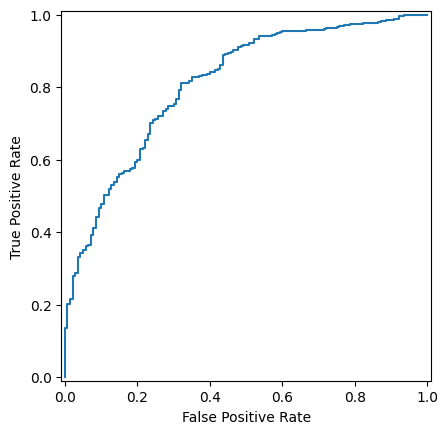

In [26]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
fpr, tpr, thresholds = roc_curve(y.argmax(axis=1), att_pred[:,1].cpu())

print(roc_auc_score(y.argmax(axis=1), att_pred[:,1].cpu()))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

0.7156375618929317


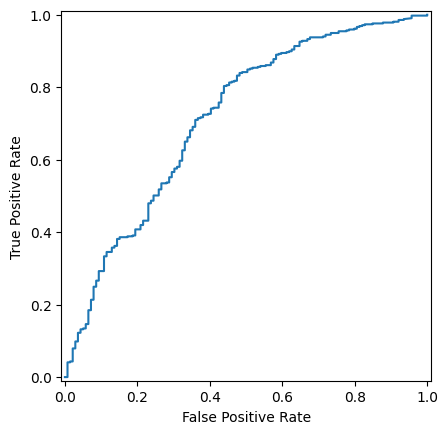

In [27]:
fpr, tpr, thresholds = roc_curve(y_test.argmax(axis=1), att_pred_test[:,1].cpu())
print(roc_auc_score(y_test.argmax(axis=1), att_pred_test[:,1].cpu()))

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

0.8568961414340553


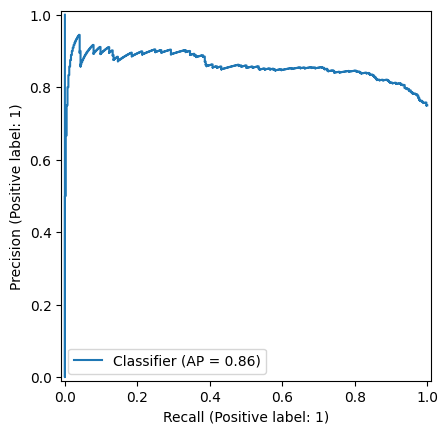

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test.argmax(axis=1), att_pred_test[:,1].cpu())
print(AUC(recall, precision))
PrecisionRecallDisplay.from_predictions(y_test.argmax(axis=1), att_pred_test[:,1].cpu())

In [29]:
f1_score(y_test.argmax(axis=1), att_pred_test.cpu().argmax(dim=1))

0.8285024154589372

<BarContainer object of 20 artists>

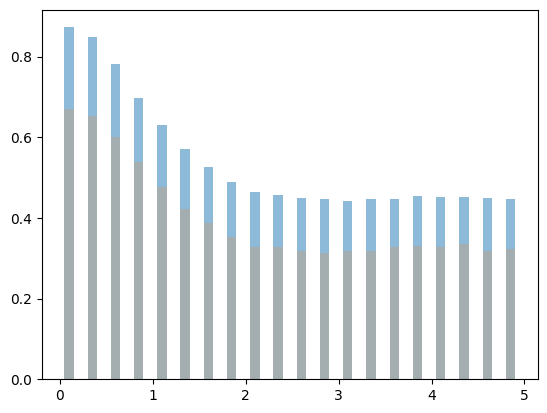

In [30]:
from matplotlib import pyplot as plt
plt.bar(scalers, np.stack(s_scores_train).mean(axis=1), alpha=0.5, width=0.1)
plt.bar(scalers, np.stack(s_scores_test).mean(axis=1), alpha=0.2, width=0.1)

<BarContainer object of 20 artists>

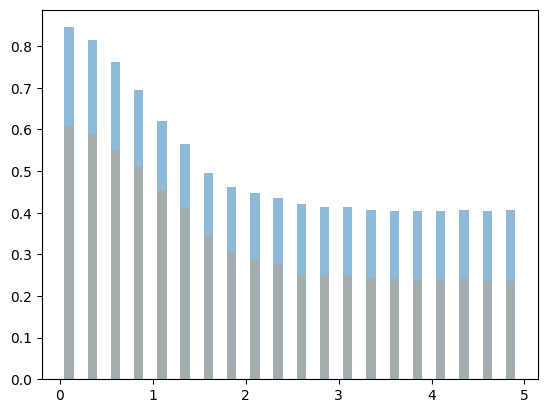

In [31]:
plt.bar(scalers, np.stack(t_scores_train).mean(axis=1), alpha=0.5, width=0.1)
plt.bar(scalers, np.stack(t_scores_test).mean(axis=1), alpha=0.2, width=0.1)

In [32]:
# s = scalers[np.argmax(all_auroc)]
# threshold = thresholds[np.argmax(all_auroc)]
# print(f'Best scaler: {s}')
# print(f'Threshold: {threshold}')
# pred_scores_train = calculate_robustness_scores(t_model, t_dataset_train, scaler=s, device=DEVICE)
# pred_scores_test = calculate_robustness_scores(t_model, t_dataset_test, scaler=s, device=DEVICE)

In [33]:
# pred_scores = np.concatenate([pred_scores_train, pred_scores_test])
# true_scores = np.concatenate([np.ones_like(pred_scores_train), np.zeros_like(pred_scores_test)])

# print(f1_score(true_scores, pred_scores>threshold))

In [34]:
# print(accuracy_score(true_scores, pred_scores>threshold))

In [35]:
# print(roc_auc_score(true_scores, pred_scores))

In [36]:
# from sklearn.metrics import RocCurveDisplay
# fpr, tpr, thresholds = roc_curve(true_scores, pred_scores)

# RocCurveDisplay(fpr=fpr, tpr=tpr).plot()